# Wstęp

Projekt dotyczy klasyfikacji obrazów ze zbioru danych The Simpsons Characters Data (link: https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset). 
Zbiór podzielono na 3 podzbiory: treningowy, walidujacy oraz testowy.
Stworzono dwie wersje zbioru danych/modele, które następnie użyto w klasyfikatorach: kNN, CNN, MLP. 

*w przypadku kNN i MLP analizie poddane tylko podzbiory treningowe i testowe

In [1]:
import numpy as np
import pandas as pd 
from tensorflow.keras.utils import load_img
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from pathlib import Path

In [2]:
FAST_RUN = False
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

In [3]:
def proc_img(filepath): #funckja tworzaca zbior danych z sciezka do pliku i nazwa postaci

    filenames = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

    filepath = pd.Series(filepath, name='filepath').astype(str)
    filenames = pd.Series(filenames, name='filenames')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, filenames], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

dataset = Path("C:/Users/Julia/Desktop/studia/6sem/io/simpsons_dataset")
filepaths = list(dataset.glob(r'**/*.jpg'))

df = proc_img(filepaths)

print(f'Liczba zdjęć (ogólna): {df.shape[0]}\n')
print(f'Postacie występujące w zbiorze danych: {df.filenames.unique()}')

Liczba zdjęć (ogólna): 41866

Postacie występujące w zbiorze danych: ['principal_skinner' 'ned_flanders' 'comic_book_guy' 'krusty_the_clown'
 'abraham_grampa_simpson' 'bart_simpson' 'sideshow_bob'
 'charles_montgomery_burns' 'apu_nahasapeemapetilon' 'homer_simpson'
 'moe_szyslak' 'milhouse_van_houten' 'lisa_simpson' 'groundskeeper_willie'
 'kent_brockman' 'marge_simpson' 'nelson_muntz' 'chief_wiggum'
 'mayor_quimby' 'waylon_smithers' 'sideshow_mel' 'edna_krabappel'
 'selma_bouvier' 'disco_stu' 'martin_prince' 'lenny_leonard'
 'troy_mcclure' 'otto_mann' 'barney_gumble' 'rainier_wolfcastle'
 'snake_jailbird' 'maggie_simpson' 'carl_carlson' 'patty_bouvier'
 'ralph_wiggum' 'agnes_skinner' 'miss_hoover' 'cletus_spuckler'
 'professor_john_frink' 'fat_tony' 'gil' 'lionel_hutz']


Interesujący jest fakt, że w podfolderach (odnośnikach do zdjęć już konkretnych bohaterów kreskówki) naszego glownego folderu znajduje się jego dokładna kopia, lecz z pomocą powyższej funkcji nie wliczamy jej do zbioru danych.

C:\Users\Julia\Desktop\studia\6sem\io\simpsons_dataset\krusty_the_clown\pic_0395.jpg


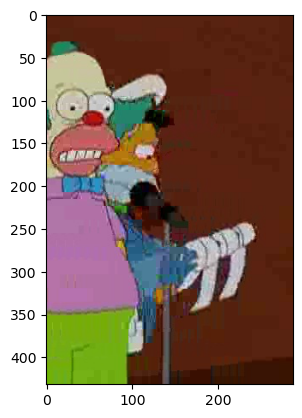

In [4]:
sample = random.choice(df['filepath'])
image = load_img(sample)
plt.imshow(image)
print(sample) #testujemy

In [5]:
#przygotowanie zbioru trenujacego, walidujacego i testujacego 
train_df, test_df = train_test_split(df,test_size=0.2, shuffle = True, random_state= 275056)
train_df, val_df =  train_test_split(train_df,test_size=0.25, shuffle = True, random_state= 275056)

In [6]:
total_train = train_df.shape[0]
total_test = test_df.shape[0]
total_val = val_df.shape[0]
batch_size = 16

CNN klasyfikator

In [7]:
#PARAMETRY PIERWSZEGO MODELU
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(len(df.filenames.unique()), activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       2

In [8]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=5)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2)

callbacks = [earlystop, learning_rate_reduction]

In [9]:
train_datagen = ImageDataGenerator( #normalizacja
    rescale=1./255,
)

train_generator = train_datagen.flow_from_dataframe( #przygotowanie zdjec do modelu
    train_df, 
    "C:/Users/Julia/Desktop/studia/6sem/io/simpsons_dataset", 
    x_col='filepath',
    y_col='filenames',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 25119 validated image filenames belonging to 42 classes.


In [10]:
val_datagen = ImageDataGenerator( #normalizacja
    rescale=1./255,
)

val_generator = val_datagen.flow_from_dataframe( #przygotowanie zdjec do modelu
    val_df, 
    "C:/Users/Julia/Desktop/studia/6sem/io/simpsons_dataset", 
    x_col='filepath',
    y_col='filenames',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 8373 validated image filenames belonging to 42 classes.


In [11]:
example_df = train_df.sample(n=1).reset_index(drop=True) #losowy obrazek do testu
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "C:/Users/Julia/Desktop/studia/6sem/io/simpsons_dataset", 
    x_col='filepath',
    y_col='filenames',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


In [17]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "C:/Users/Julia/Desktop/studia/6sem/io/simpsons_dataset", 
    x_col='filepath',
    y_col='filenames',
    target_size=IMAGE_SIZE,
    batch_size = batch_size,
    shuffle = False,
    class_mode = 'categorical'
)

Found 8374 validated image filenames belonging to 42 classes.


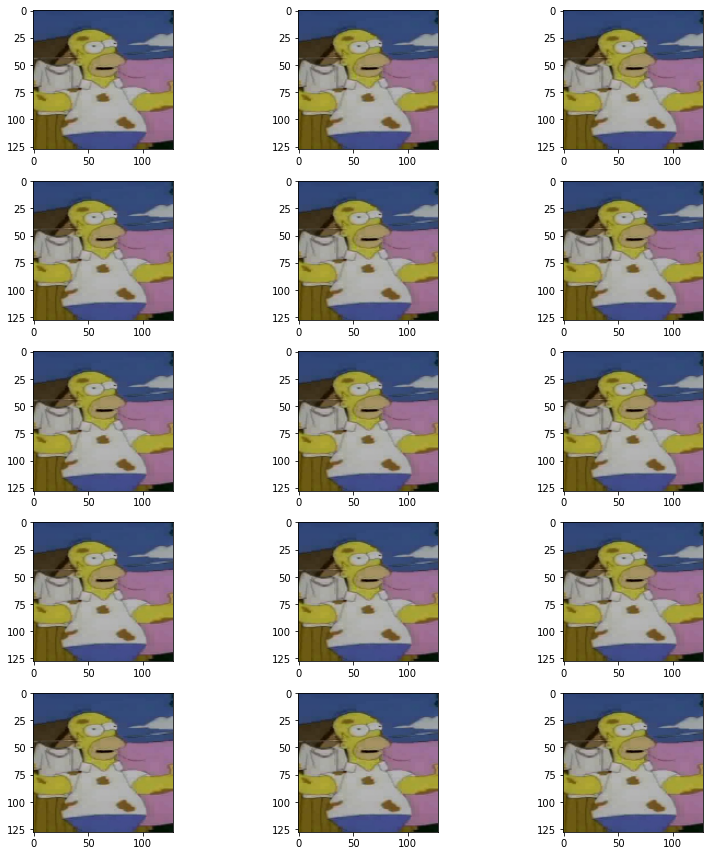

In [12]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show() #test 

In [13]:
epochs=3 if FAST_RUN else 50 #sprawadzamy optymalnosc modelu
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data = val_generator,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)
#loss: 0.0390 - accuracy: 0.9877 - lr: 0.0010

<ipython-input-13-0658651fb6e6>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
1569/1569 [==============================] - 431s 273ms/step - loss: 2.1076 - accuracy: 0.4730 - val_loss: 1.3977 - val_accuracy: 0.6312 - lr: 0.0010
Epoch 2/50
1569/1569 [==============================] - 411s 262ms/step - loss: 1.0158 - accuracy: 0.7286 - val_loss: 0.8080 - val_accuracy: 0.7935 - lr: 0.0010
Epoch 3/50
1569/1569 [==============================] - 409s 261ms/step - loss: 0.6655 - accuracy: 0.8210 - val_loss: 0.5416 - val_accuracy: 0.8619 - lr: 0.0010
Epoch 4/50
1569/1569 [==============================] - 409s 261ms/step - loss: 0.4751 - accuracy: 0.8709 - val_loss: 0.4909 - val_accuracy: 0.8803 - lr: 0.0010
Epoch 5/50
1569/1569 [==============================] - 409s 261ms/step - loss: 0.3607 - accuracy: 0.9014 - val_loss: 0.3786 - val_accuracy: 0.9060 - lr: 0.0010
Epoch 6/50
1569/1569 [==============================] - 409s 261ms/step - loss: 0.2828 - accuracy: 0.9214 - val_loss: 0.3431 - val_accuracy: 0.9142 - lr: 0.0010
Epoch 7/50
1569/1569 [============

In [14]:
model.save_weights("model.h5") #zapis

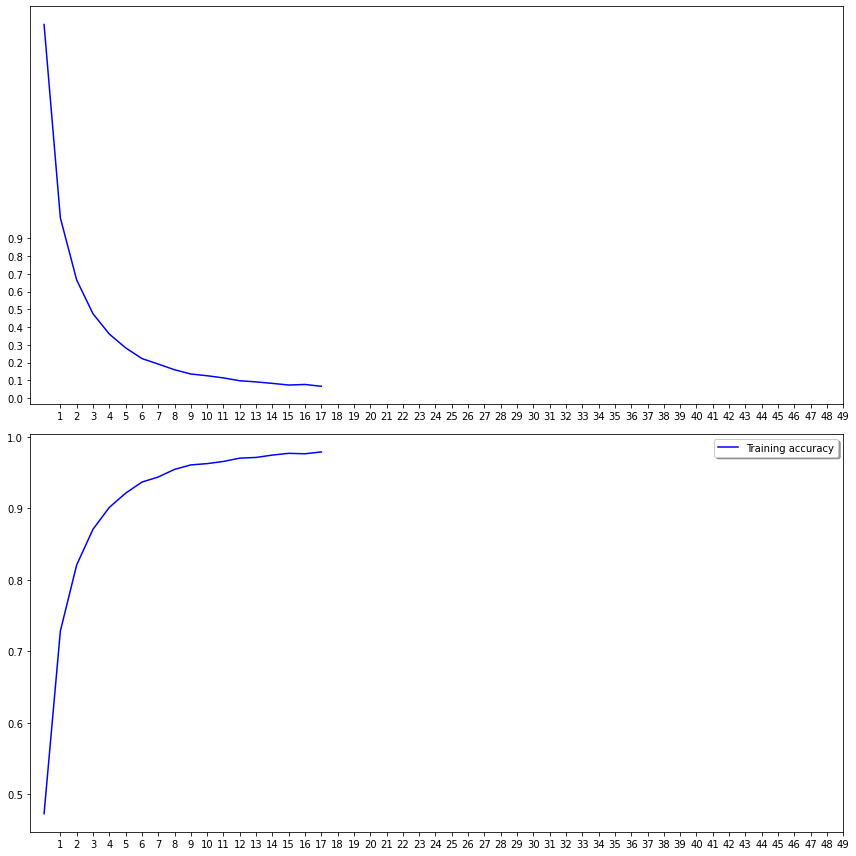

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show() #krzywe uczenia sie

In [18]:
predict = model.predict(test_generator,steps=np.ceil(total_test/batch_size))
predict = np.argmax(predict,axis=1)

524/524 [==============================] - 29s 54ms/step


In [19]:
p = test_generator.classes
q = predict
p = np.array(p)

In [20]:
tst = train_generator.class_indices
tst = dict((v,k) for k,v in tst.items())
pred = [tst[k] for k in q]

In [21]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(test_df['filenames'],pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%') #jak bardzo dobry model

Accuracy on the test set: 91.40%


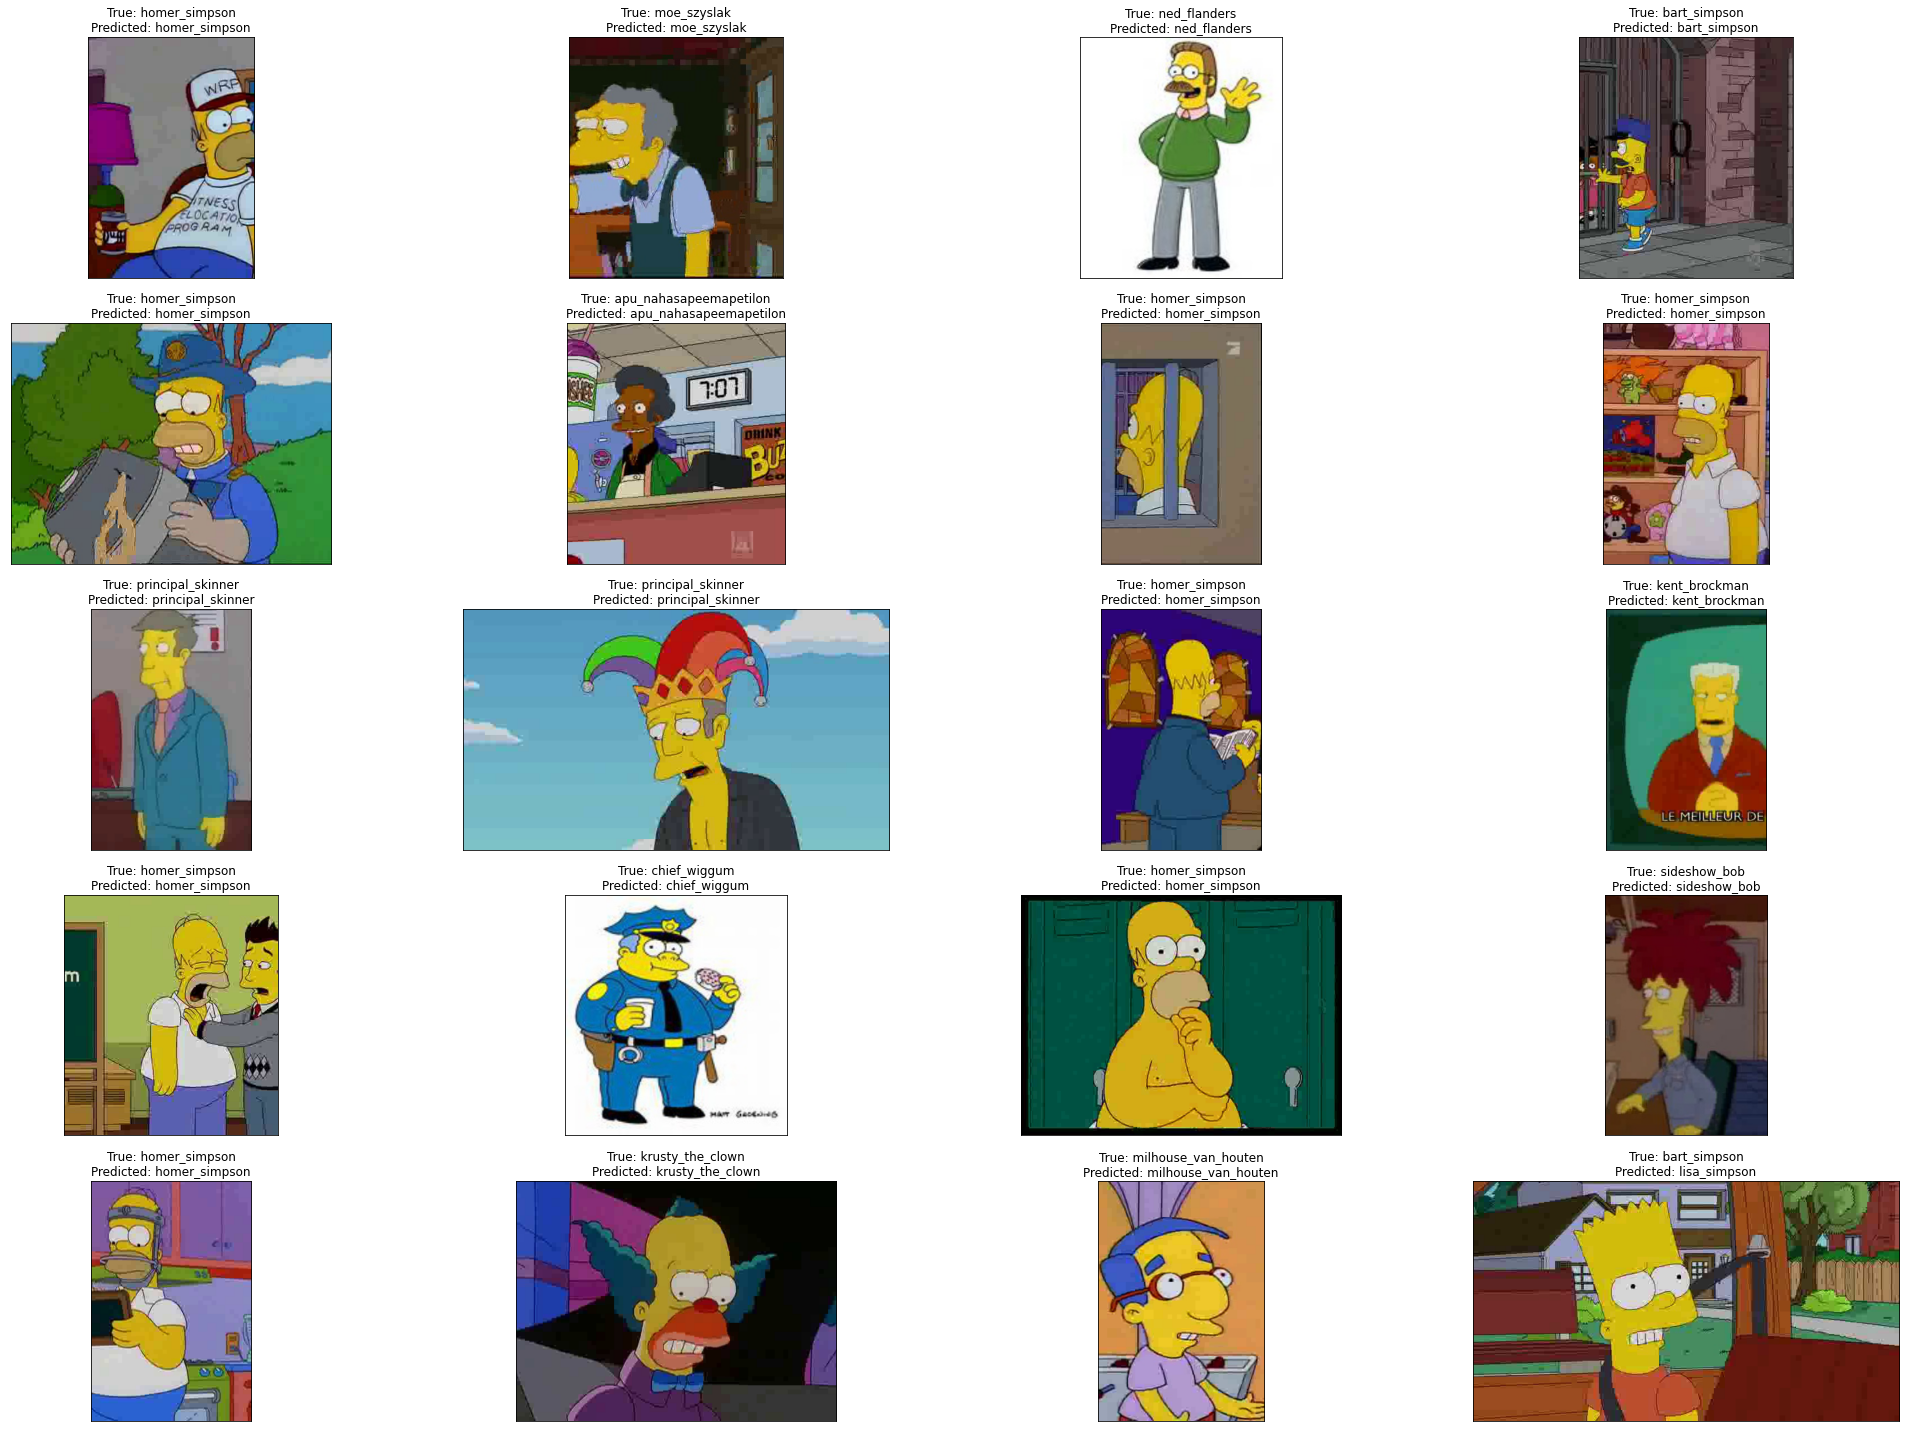

In [22]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(30, 20),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.filepath.iloc[i]))
    ax.set_title(f"True: {test_df.filenames.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show() #postacie - ich prawdziwa tozsamosc vs predykcja

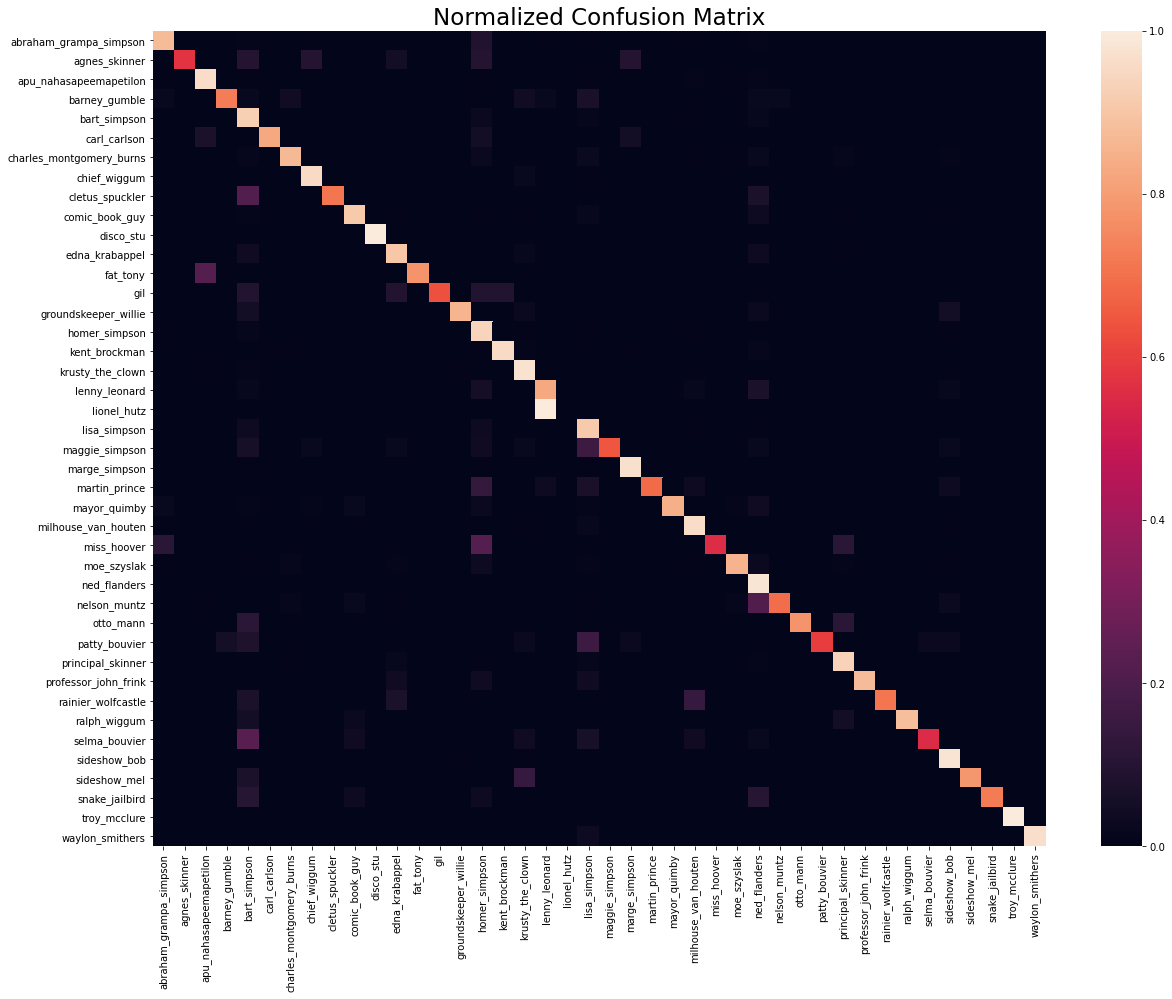

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(test_df['filenames'],pred, normalize='true') #macierz predykcji
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(df.filenames.unique())), yticklabels = sorted(set(df.filenames.unique())))
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.show()

In [24]:
from sklearn.metrics import classification_report #jak wygladaja klasyfikacje dla poszczegolnych postaci
class_report = classification_report(test_df['filenames'],pred, zero_division=1)
print(class_report)

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.95      0.87      0.91       384
           agnes_skinner       1.00      0.57      0.73        21
  apu_nahasapeemapetilon       0.95      0.96      0.96       255
           barney_gumble       0.91      0.73      0.81        44
            bart_simpson       0.83      0.92      0.87       540
            carl_carlson       0.94      0.83      0.88        41
charles_montgomery_burns       0.96      0.87      0.91       507
            chief_wiggum       0.98      0.96      0.97       395
         cletus_spuckler       1.00      0.71      0.83        14
          comic_book_guy       0.94      0.91      0.93       181
               disco_stu       1.00      1.00      1.00         2
          edna_krabappel       0.86      0.91      0.88       191
                fat_tony       1.00      0.78      0.88         9
                     gil       1.00      0.64      0.78        11
    groun

In [25]:
#DRUGI MODEL (ROZBUDOWANY)
FAST_RUN = False
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 1

In [26]:
model.build(input_shape=(64,64, 1))

model = Sequential()

model.add(Conv2D(96, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu',input_shape=(64,64, 1))) 
model.add(Conv2D(96, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.25)) 

model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu')) 
model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.45)) 

model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.45)) 

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(df.filenames.unique()), activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 96)        960       
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 60, 96)        83040     
                                                                 
 batch_normalization_4 (Batc  (None, 60, 60, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 96)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 30, 30, 96)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)      

In [27]:
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5)

callbacks = [earlystop, learning_rate_reduction]


In [28]:
train_datagen = ImageDataGenerator( #normalizacja
    rescale=1./150
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "C:/Users/Julia/Desktop/studia/6sem/io/simpsons_dataset", 
    x_col='filepath',
    y_col='filenames',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
    color_mode='grayscale',
    shuffle=True,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="reflect" #wysokoprztworzone obrazy
)

Found 25119 validated image filenames belonging to 42 classes.


In [29]:
val_datagen = ImageDataGenerator( #normalizacja
    rescale=1./150
)

val_generator = val_datagen.flow_from_dataframe(
    val_df, 
    "C:/Users/Julia/Desktop/studia/6sem/io/simpsons_dataset", 
    x_col='filepath',
    y_col='filenames',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
    color_mode='grayscale',
    shuffle=True,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="reflect" #wysokoprztworzone obrazy
)

Found 8373 validated image filenames belonging to 42 classes.


In [30]:
example_df = train_df.sample(n=1).reset_index(drop=True) #test
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "C:/Users/Julia/Desktop/studia/6sem/io/simpsons_dataset", 
 x_col='filepath',
    y_col='filenames',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
    color_mode='grayscale',
    shuffle=True,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="reflect"
)

Found 1 validated image filenames belonging to 1 classes.


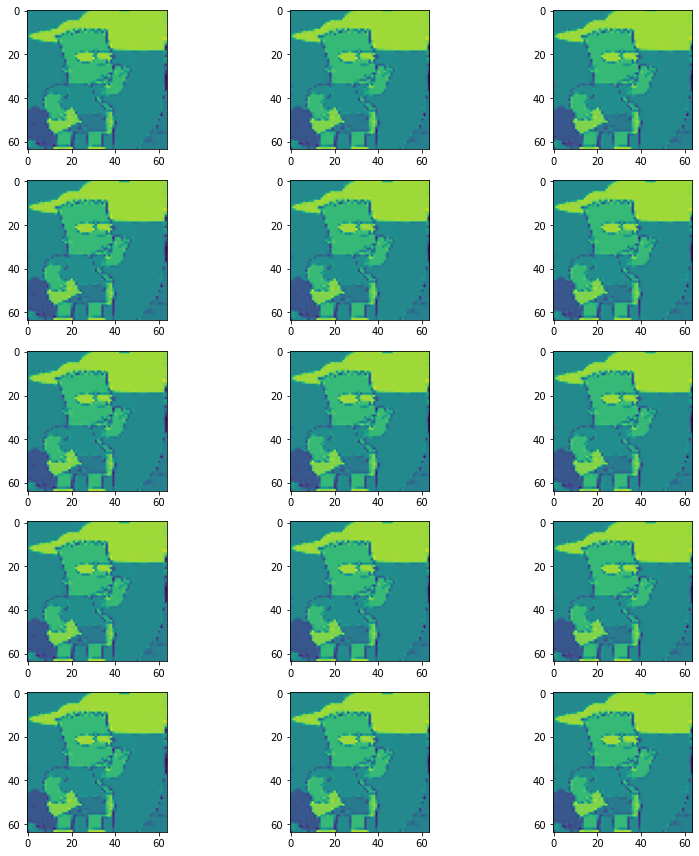

In [31]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [33]:
epochs=3 if FAST_RUN else 50 #optymalnosc modelu
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data = val_generator,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)
# loss: 0.6736 - accuracy: 0.8311 - val_loss: 0.6810 - val_accuracy: 0.8588 - lr: 0.0010

<ipython-input-33-c062a267b37d>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
1569/1569 [==============================] - 925s 586ms/step - loss: 3.4397 - accuracy: 0.1009 - val_loss: 3.0176 - val_accuracy: 0.1691 - lr: 0.0010
Epoch 2/50
1569/1569 [==============================] - 923s 588ms/step - loss: 3.0383 - accuracy: 0.1513 - val_loss: 2.9233 - val_accuracy: 0.1668 - lr: 0.0010
Epoch 3/50
1569/1569 [==============================] - 926s 590ms/step - loss: 2.8974 - accuracy: 0.1903 - val_loss: 3.2270 - val_accuracy: 0.0456 - lr: 0.0010
Epoch 4/50
1569/1569 [==============================] - 922s 588ms/step - loss: 2.7656 - accuracy: 0.2364 - val_loss: 2.9296 - val_accuracy: 0.1959 - lr: 0.0010
Epoch 5/50
1569/1569 [==============================] - 922s 588ms/step - loss: 2.6063 - accuracy: 0.2788 - val_loss: 2.4068 - val_accuracy: 0.3417 - lr: 0.0010
Epoch 6/50
1569/1569 [==============================] - 925s 589ms/step - loss: 2.4270 - accuracy: 0.3329 - val_loss: 2.1644 - val_accuracy: 0.4196 - lr: 0.0010
Epoch 7/50
1569/1569 [============

In [34]:
model.save_weights("model.h5")

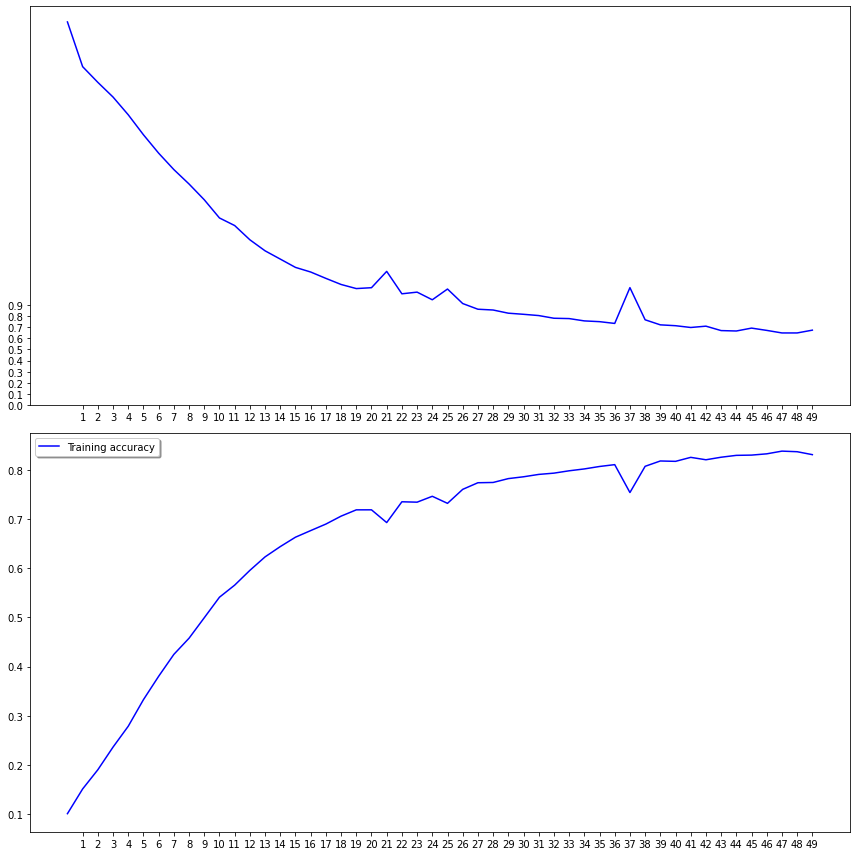

In [35]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [37]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "C:/Users/Julia/Desktop/studia/6sem/io/simpsons_dataset", 
    x_col='filepath',
    y_col='filenames',
    target_size=IMAGE_SIZE,
    batch_size = batch_size,
    color_mode='grayscale',
    shuffle = False,
    class_mode = 'categorical'
)

Found 8374 validated image filenames belonging to 42 classes.


In [38]:
predict = model.predict(test_generator,steps=np.ceil(total_test/batch_size))
predict = np.argmax(predict,axis=1)

524/524 [==============================] - 34s 64ms/step


In [39]:
p = test_generator.classes
q = predict
p = np.array(p)

In [40]:
tst = train_generator.class_indices
tst = dict((v,k) for k,v in tst.items())
pred = [tst[k] for k in q]

In [41]:
acc = accuracy_score(test_df['filenames'],pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

Accuracy on the test set: 51.44%


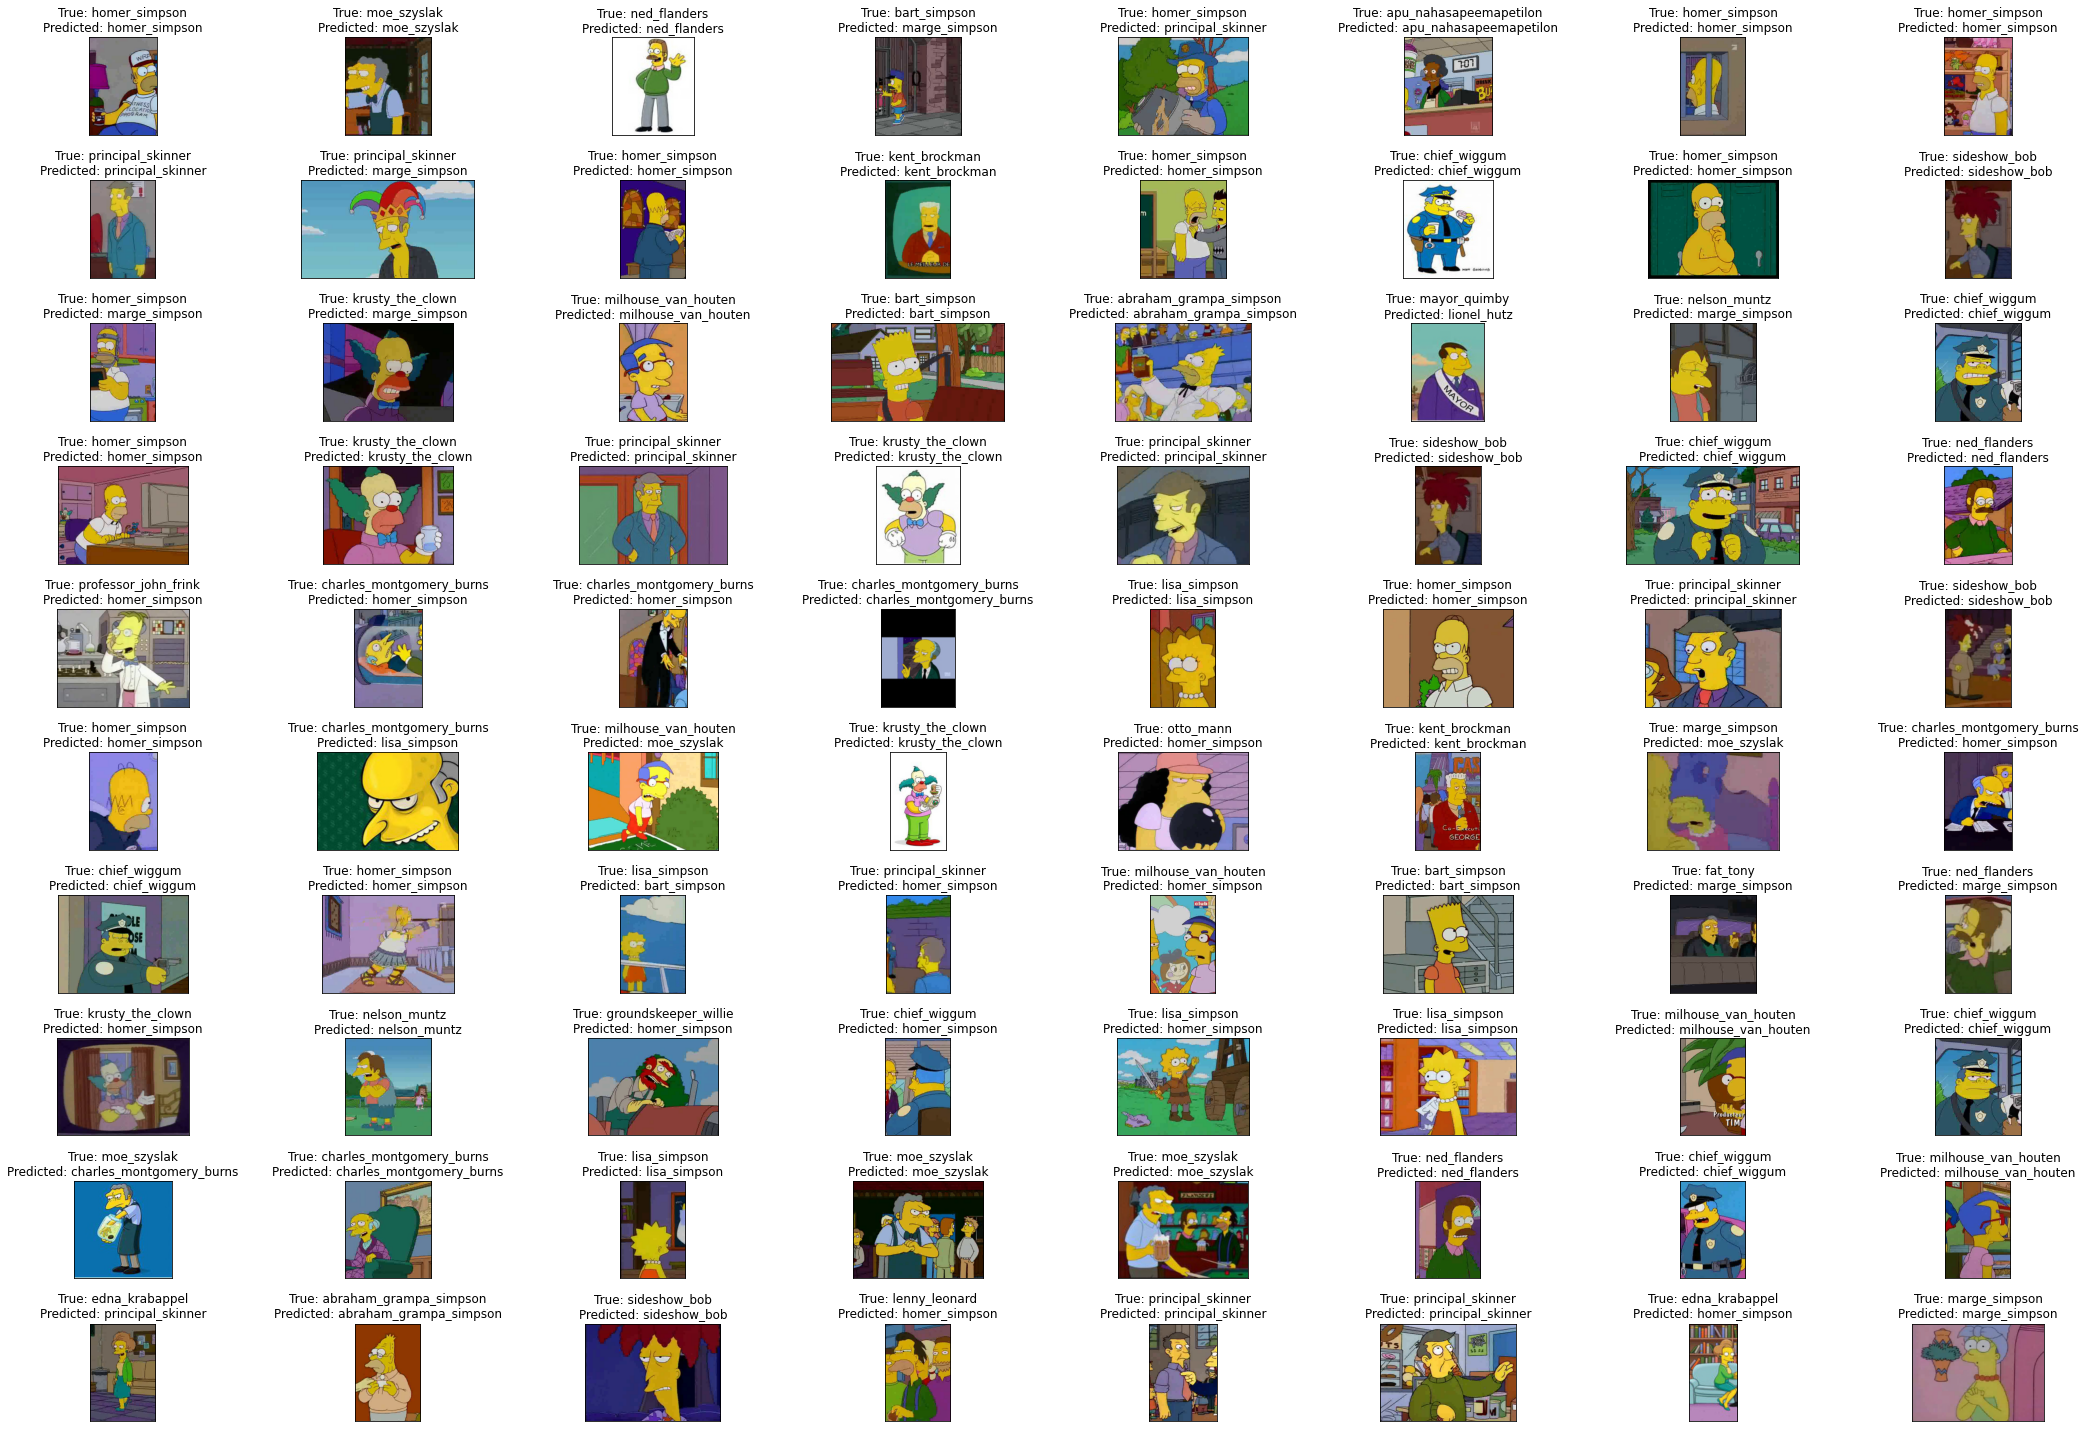

In [42]:
fig, axes = plt.subplots(nrows=10, ncols=8, figsize=(30, 20),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.filepath.iloc[i]))
    ax.set_title(f"True: {test_df.filenames.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

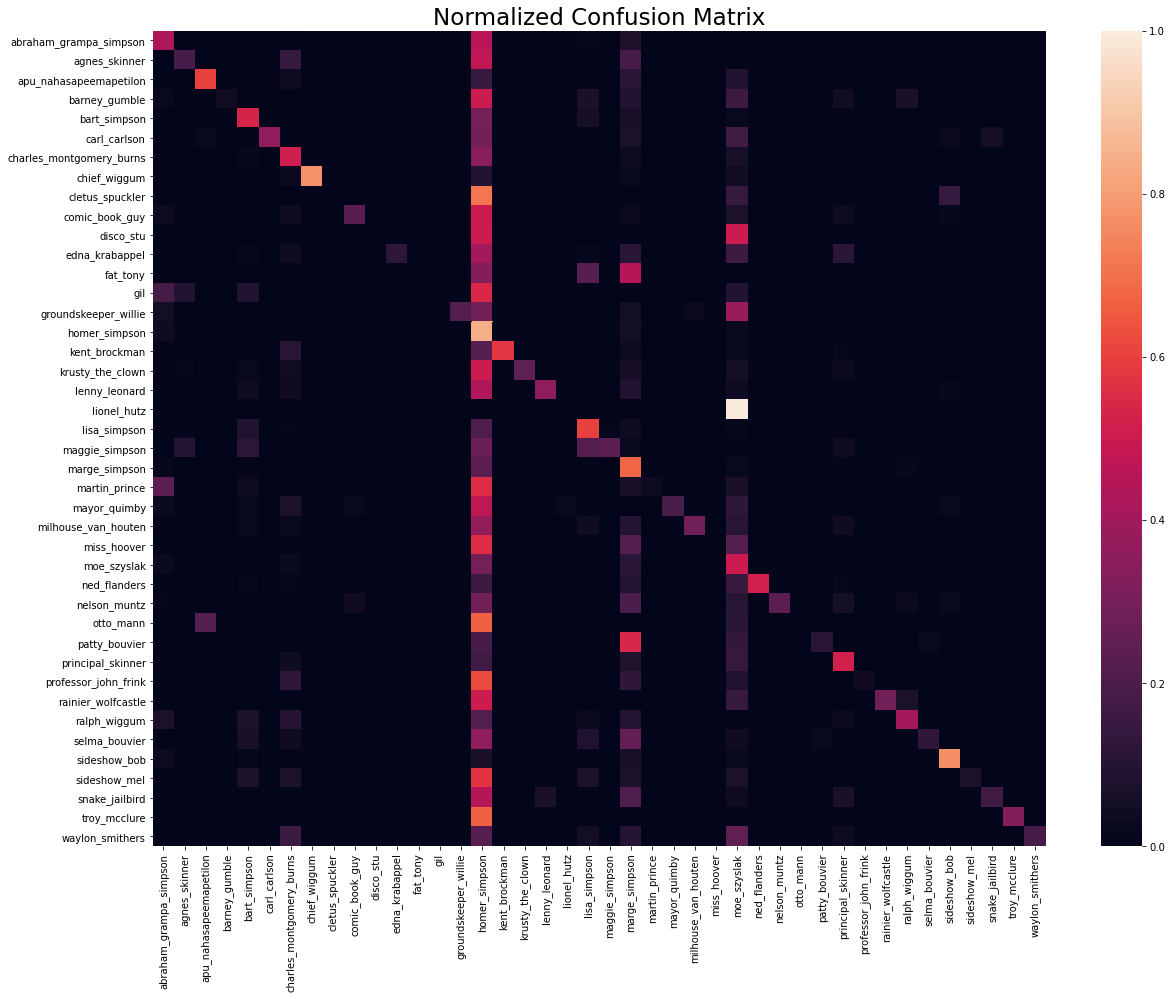

In [43]:
cf_matrix = confusion_matrix(test_df['filenames'],pred, normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(df.filenames.unique())), yticklabels = sorted(set(df.filenames.unique())))
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.show()

In [44]:
class_report = classification_report(test_df['filenames'],pred, zero_division=1)
print(class_report)

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.58      0.43      0.49       384
           agnes_skinner       0.11      0.19      0.14        21
  apu_nahasapeemapetilon       0.94      0.60      0.74       255
           barney_gumble       0.67      0.05      0.09        44
            bart_simpson       0.69      0.53      0.60       540
            carl_carlson       0.94      0.37      0.53        41
charles_montgomery_burns       0.58      0.51      0.54       507
            chief_wiggum       0.98      0.77      0.87       395
         cletus_spuckler       0.00      0.00      0.00        14
          comic_book_guy       0.78      0.23      0.36       181
               disco_stu       0.00      0.00      0.00         2
          edna_krabappel       1.00      0.12      0.21       191
                fat_tony       0.00      0.00      0.00         9
                     gil       0.00      0.00      0.00        11
    groun

MLP klasyfikator

In [19]:
# I MODEL
train_datagen = ImageDataGenerator(
    rescale=1./255,
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "C:/Users/Julia/Desktop/studia/6sem/io/simpsons_dataset", 
    x_col='filepath',
    y_col='filenames',
    target_size=(16,16), #zmiana wielkosci obrazkow z uwagi, ze trzeba stworzyc liste pikseli
    class_mode='categorical',
    batch_size=batch_size
)

Found 25119 validated image filenames belonging to 42 classes.


In [20]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "C:/Users/Julia/Desktop/studia/6sem/io/simpsons_dataset", 
    x_col='filepath',
    y_col='filenames',
    target_size=(16,16),
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 8374 validated image filenames belonging to 42 classes.


In [10]:
pixel_list = [] #lista pikseli
for i in range(int(np.ceil(len(train_df) / batch_size))):
    batch = next(train_generator)
    X_batch = batch[0]  


    for j in range(min(batch_size, len(X_batch))):
        image = X_batch[j]
        pixel_values = image.tolist()
        pixel_list.append(pixel_values)

In [11]:
pixel_list_test = []
for i in range(int(np.ceil(len(test_df) / batch_size))):
    batch = next(test_generator)
    X_batch = batch[0]  


    for j in range(min(batch_size, len(X_batch))):
        image = X_batch[j]
        pixel_values = image.tolist()
        pixel_list_test.append(pixel_values)


In [12]:
X = np.array(pixel_list)
print(X.shape)
num_samples, height, width, channels = X.shape
X = X.reshape(num_samples, height * width * channels)
print(X.shape)
y = np.array(train_df['filenames'])

(25119, 16, 16, 3)
(25119, 768)


In [13]:
X_test = np.array(pixel_list_test)
print(X_test.shape)
num_samples_t, height_t, width_t, channels_t = X_test.shape
X_test = X_test.reshape(num_samples_t, height_t * width_t * channels_t)
print(X_test.shape)
y_test = np.array(test_df['filenames'])

(8374, 16, 16, 3)
(8374, 768)


In [17]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=[300, 100], 
                          activation='relu', 
                          early_stopping=True,
                          random_state=275056)
clf.fit(X, y)

score = clf.score(X, y)
print('Validation accuracy:', score)
#Validation accuracy: 0.1096

Validation accuracy: 0.10967793303873562


In [26]:
#testowy
clf = MLPClassifier(hidden_layer_sizes=[300, 100], 
                          activation='relu', 
                          early_stopping=True,
                          random_state=275056)
clf.fit(X_test, y_test)

score = clf.score(X_test, y_test)
print('Validation accuracy:', score)
#Validation accuracy: 0.9546

Validation accuracy: 0.9546214473369955


In [35]:
#II MODEL
train_datagen = ImageDataGenerator( #normalizacja
    rescale=1./150
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "C:/Users/Julia/Desktop/studia/6sem/io/simpsons_dataset", 
    x_col='filepath',
    y_col='filenames',
    target_size=(16,16),
    class_mode='categorical',
    batch_size=batch_size,
    color_mode='grayscale',
    shuffle=True,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="reflect" #wysokoprztworzone obrazy
)

Found 25119 validated image filenames belonging to 42 classes.


In [47]:
test_gen = ImageDataGenerator(rescale=1./150)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "C:/Users/Julia/Desktop/studia/6sem/io/simpsons_dataset", 
    x_col='filepath',
    y_col='filenames',
    target_size=(16,16),
    batch_size = batch_size,
    shuffle = False,
    color_mode='grayscale',
    class_mode = 'categorical'
)

Found 8374 validated image filenames belonging to 42 classes.


In [37]:
pixel_list2 = []
for i in range(int(np.ceil(len(train_df) / batch_size))):
    batch = next(train_generator)
    X_batch = batch[0]  


    for j in range(min(batch_size, len(X_batch))):
        image = X_batch[j]
        pixel_values = image.tolist()
        pixel_list2.append(pixel_values)

In [48]:
pixel_list_test2 = []
for i in range(int(np.ceil(len(test_df) / batch_size))):
    batch = next(test_generator)
    X_batch = batch[0]  


    for j in range(min(batch_size, len(X_batch))):
        image = X_batch[j]
        pixel_values = image.tolist()
        pixel_list_test2.append(pixel_values)


In [41]:
X2 = np.array(pixel_list2)
print(X2.shape)
num_samples, height, width, channels = X2.shape
X2 = X2.reshape(num_samples, height * width * channels)
print(X2.shape)
y2 = np.array(train_df['filenames'])

(25119, 16, 16, 1)
(25119, 256)


In [49]:
X2_test = np.array(pixel_list_test2)
print(X2_test.shape)
num_samples_t, height_t, width_t, channels_t = X2_test.shape
X2_test = X2_test.reshape(num_samples_t, height_t * width_t * channels_t)
print(X2_test.shape)
y2_test = np.array(test_df['filenames'])

(8374, 16, 16, 1)
(8374, 256)


In [34]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=[300, 100], 
                          activation='relu', 
                          early_stopping=True,
                          random_state=275056)
clf.fit(X, y)

Validation accuracy: 0.10748835542816194


In [57]:
from sklearn import metrics
y2_pred = clf.predict(X2_test)
print(metrics.accuracy_score(y2_test, y2_pred))
#predykcja: 0.0672

0.06723190828755672


kNN

In [21]:
#uzyjemy modeli z poprzedniego zadania
#I MODEL
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X, y)

KNeighborsClassifier(n_neighbors=3)

In [22]:
from sklearn import metrics
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.051349414855505135


In [27]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X, y)

KNeighborsClassifier(n_neighbors=15)

In [28]:
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.06484356341055648


In [33]:
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X, y)

KNeighborsClassifier(n_neighbors=25)

In [34]:
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.06997850489610699


In [50]:
#II MODEL
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X2, y2)

KNeighborsClassifier(n_neighbors=3)

In [52]:
y2_pred = clf.predict(X2_test)
print(metrics.accuracy_score(y2_test, y2_pred))

0.0530212562694053


In [53]:
clf = KNeighborsClassifier(n_neighbors=15)
clf.fit(X2, y2)

KNeighborsClassifier(n_neighbors=15)

In [54]:
y2_pred = clf.predict(X2_test)
print(metrics.accuracy_score(y2_test, y2_pred))

0.06281347026510628


In [55]:
clf = KNeighborsClassifier(n_neighbors=25)
clf.fit(X2, y2)

KNeighborsClassifier(n_neighbors=25)

In [56]:
y2_pred = clf.predict(X2_test)
print(metrics.accuracy_score(y2_test, y2_pred))

0.06723190828755672


Podsumowanie

Na podstawie powyższych wyników, możemy wywnioskować, że mniej przetworzone obrazy zostają lepiej rozpoznawane przez klasyfikatory.

Bibliografia

https://www.tensorflow.org/tutorials/images/cnn?hl=pl
https://realpython.com/knn-python/